In [1]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import average_precision_score, precision_recall_curve, precision_recall_fscore_support

In [2]:
### READING DATASET ###

# Paths
dataset_path = 'Dataset'
games_dir = next(os.walk(dataset_path))[1]

tag_to_skip = ['highlights', 'highlights2', '.DS_Store', '.git']
dt = np.dtype([('a', float), ('b', float), ('name', np.unicode_, 16)])

# Iterating through games
games_data = []
games_path = [os.path.join(dataset_path, g) for g in games_dir]
for path in games_path:
    game_name = os.path.basename(path)
    if game_name != 'ned_svk':
        game_info = os.listdir(path)
        data = dict()
        for info in game_info:
            tag_name = os.path.splitext(info)[0]
            if tag_name not in tag_to_skip:
                csv_file = os.path.join(path, info)
                if tag_name == 'highlights_boundaries':
                    data_value = np.genfromtxt(csv_file, delimiter=',', dtype=None)
                else:
                    data_value = np.fromfile(csv_file, dtype=np.float64)
                data[tag_name] = data_value
            data['name'] = game_name
        games_data.append(data)

games_backup = games_data[:]

C:\Users\v-pakova\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:23: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.


In [3]:
### REMOVENDO VALORES CORRELACIONADOS ###

to_remove = ['em_mcs_energy', 'em_mcs_energy_diff', 'em_mcs_energy_diff_ascending']
for game in games_data:
    for tag in to_remove:
        del game[tag]

In [4]:
### CRIANDO VETOR DE GT ###

normal_cases = ['Normal', 'Inicio', 'Fim']
to_skip = ['name', 'highlights_boundaries']

for game in games_data:
    h = game['highlights_boundaries']
    end = h[-1][0]
    gt = np.zeros(end)
    slices = []
    for line in h:
        tag = line[2].decode('UTF-8').split(' ')
        name = [t for t in tag if t != ''][0]
        if name not in normal_cases:
            gt[line[0]-1:line[1]] = 1
        else:
            slices.append([line[0], line[1], name])

    slices = slices[::-1]
    ## Removing data not to be considered ###
    for k, values in game.items():
        if k not in to_skip:
            for sl in slices:
                if 'Fim' in sl[2]:
                    values = np.delete(values, range(sl[0], len(values)))
                if 'Normal' in sl[2]:
                    values = np.delete(values, range(sl[0], sl[1]))
                if 'Inicio' in sl[2]:
                    values = np.delete(values, range(0, sl[0]))
        game[k] = values
                    
            
    game['gt'] = gt
    del game['highlights_boundaries']

C:\Users\v-pakova\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:27: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


In [5]:
for game in games_data:
    print(game['name'])
    for k, v in game.items():
        print('\t{} - {}'.format(k, len(v)))

amg_vas
	dc_hue_mean - 72098
	name - 7
	dc_percent - 72098
	em_cs_energy - 72098
	em_cs_energy_diff - 72098
	em_cs_energy_diff_ascending - 72098
	em_st_energy - 72098
	em_st_energy_diff - 72098
	em_st_energy_diff_ascending - 72098
	pc_delta - 72098
	pc_rho - 72098
	pc_theta - 72098
	pc_var_delta - 72098
	pc_var_theta - 72098
	pm_pitch - 72098
	pm_pitch_diff - 72098
	pm_pitch_diff_ascending - 72098
	gt - 209234
arg_ger
	dc_hue_mean - 52742
	name - 7
	dc_percent - 52742
	em_cs_energy - 52742
	em_cs_energy_diff - 52742
	em_cs_energy_diff_ascending - 52742
	em_st_energy - 52742
	em_st_energy_diff - 52742
	em_st_energy_diff_ascending - 52742
	pc_delta - 52742
	pc_rho - 52740
	pc_theta - 52742
	pc_var_delta - 52742
	pc_var_theta - 52742
	pm_pitch - 52742
	pm_pitch_diff - 52742
	pm_pitch_diff_ascending - 52742
	gt - 171536
arg_mex
	dc_hue_mean - 81362
	name - 7
	dc_percent - 81362
	em_cs_energy - 81362
	em_cs_energy_diff - 81362
	em_cs_energy_diff_ascending - 81362
	em_st_energy - 81362
	em_s

In [6]:
### CORTANDO VALORES EXCEDENTES PARA QUE TODOS OS DADOS TENHAM O MESMO TAMANHO ###

for game in games_data:
    values = [len(v) for k, v in game.items() if k not in ['name']]
    min_l = min(values)
    for k, v in game.items():
        if len(v) > min_l:
            game[k] = v[:min_l]
            

### ZERO PADDING ###
max_length = 0
for game in games_data:
    values = [len(v) for k, v in game.items() if k not in ['name']]
    max_length = max(values) if max(values)>max_length else max_length

for game in games_data:
    for k, v in game.items():
        if k not in ['name']:
            zero_v = np.zeros(max_length)
            if len(v) < max_length:
                zero_v[:len(v)] = v
                game[k] = zero_v

In [7]:
for game in games_data:
    print(game['name'])
    for k, v in game.items():
        print('\t{} - {}'.format(k, len(v)))

amg_vas
	dc_hue_mean - 83370
	name - 7
	dc_percent - 83370
	em_cs_energy - 83370
	em_cs_energy_diff - 83370
	em_cs_energy_diff_ascending - 83370
	em_st_energy - 83370
	em_st_energy_diff - 83370
	em_st_energy_diff_ascending - 83370
	pc_delta - 83370
	pc_rho - 83370
	pc_theta - 83370
	pc_var_delta - 83370
	pc_var_theta - 83370
	pm_pitch - 83370
	pm_pitch_diff - 83370
	pm_pitch_diff_ascending - 83370
	gt - 83370
arg_ger
	dc_hue_mean - 83370
	name - 7
	dc_percent - 83370
	em_cs_energy - 83370
	em_cs_energy_diff - 83370
	em_cs_energy_diff_ascending - 83370
	em_st_energy - 83370
	em_st_energy_diff - 83370
	em_st_energy_diff_ascending - 83370
	pc_delta - 83370
	pc_rho - 83370
	pc_theta - 83370
	pc_var_delta - 83370
	pc_var_theta - 83370
	pm_pitch - 83370
	pm_pitch_diff - 83370
	pm_pitch_diff_ascending - 83370
	gt - 83370
arg_mex
	dc_hue_mean - 83370
	name - 7
	dc_percent - 83370
	em_cs_energy - 83370
	em_cs_energy_diff - 83370
	em_cs_energy_diff_ascending - 83370
	em_st_energy - 83370
	em_st_

In [8]:
### DIVIDING SPLITS FROM TRAIN, EVAL, TEST ###

from sklearn.model_selection import train_test_split

games_name = [g['name'] for g in games_data]
games_train1, games_test = train_test_split(games_name, test_size=0.15)
games_train2, games_val = train_test_split(games_train1, test_size=0.05)

print('Total train: {}'.format(len(games_train2)))
print('Total test: {}'.format(len(games_test)))
print('Total val: {}'.format(len(games_val)))

Total train: 22
Total test: 5
Total val: 2


In [9]:
for i, tag_name in enumerate(games_data[10].keys()):
    print('{} - {}'.format(i, tag_name))
    if tag_name == 'name':
        name_id = i
    if tag_name == 'gt':
        gt_id = i
        
print('\nnme_id: {}, gt_id: {}'.format(name_id, gt_id))

0 - dc_hue_mean
1 - name
2 - dc_percent
3 - em_cs_energy
4 - em_cs_energy_diff
5 - em_cs_energy_diff_ascending
6 - em_st_energy
7 - em_st_energy_diff
8 - em_st_energy_diff_ascending
9 - pc_delta
10 - pc_rho
11 - pc_theta
12 - pc_var_delta
13 - pc_var_theta
14 - pm_pitch
15 - pm_pitch_diff
16 - pm_pitch_diff_ascending
17 - gt

nme_id: 1, gt_id: 17


In [10]:
X_train = []
y_train = []

for game in games_data:
    if game['name'] in games_train1:
        values_array = np.array(list(game.values()))
        # Getting GT
        y_train += list(values_array[gt_id])
        
        # Removing name and GT to train
        values_array = np.delete(values_array, (max(name_id, gt_id)), axis=0)
        values_array = np.delete(values_array, (min(name_id, gt_id)), axis=0)
        
        values_array = np.array(values_array[:].tolist())
        if len(X_train) == 0:
            X_train = np.transpose(values_array)
        else:
            X_train = np.concatenate((X_train, np.transpose(values_array)))
y_train = np.array(y_train)    


X_test = []
y_test = []

for game in games_data:
    if game['name'] in games_test:
        values_array = np.array(list(game.values()))
        # Getting GT
        y_test += list(values_array[gt_id])
        
        # Removing name and GT to train
        values_array = np.delete(values_array, (max(name_id, gt_id)), axis=0)
        values_array = np.delete(values_array, (min(name_id, gt_id)), axis=0)
        
        values_array = np.array(values_array[:].tolist())
        if len(X_test) == 0:
            X_test = np.transpose(values_array)
        else:
            X_test = np.concatenate((X_test, np.transpose(values_array)))
y_test = np.array(y_test)
            

print('Train', X_train.shape, y_train.shape)
print('Test', X_test.shape, y_test.shape)

Train (2000880, 16) (2000880,)
Test (416850, 16) (416850,)


RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=10, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
Average precision-recall score: 0.01
Precision: [0.99007557 0.        ]
Recall: [1. 0.]


C:\Users\v-pakova\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


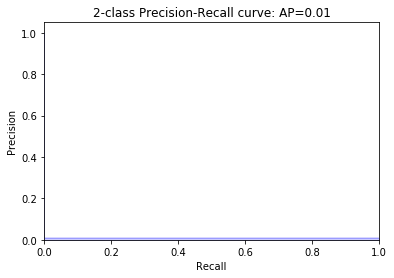

In [18]:
clf = RandomForestClassifier(class_weight='balanced', max_depth=10)
clf.fit(X_train, y_train)
print(clf)

# Getting predictions
y_predictions = clf.predict_proba(X_test)
y_score = clf.predict(X_test)

# Calculating average precision
average_precision = average_precision_score(y_test, y_score)
print('Average precision-recall score: {0:0.2f}'.format(average_precision))

# Getting precision and recall
p_r_fs = precision_recall_fscore_support(y_test, y_score)
print('Precision: {}'.format(p_r_fs[0]))
print('Recall: {}'.format(p_r_fs[1]))

# Plotting PR curve
precision, recall, _ = precision_recall_curve(y_test, y_predictions[:, 1])

plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
plt.show()

In [19]:
tp = [0, 0]
fp = [0, 0]

for i, label in enumerate(y_test):
    label = int(label)
    if int(y_score[i]) == label:
        tp[label] += 1
    if int(y_score[i]) != label:
        fp[label] += 1

print(tp)
print(fp)

[412713, 0]
[0, 4137]


In [20]:
new_keys = list(games_data[0].keys())
new_keys.remove('gt')
new_keys.remove('name')

for feature in range(X_train.shape[1]):
    new_X_train = X_train[:, feature]
    new_X_test = X_test[:, feature]
    
#     start_time = time.clock()
    new_clf = RandomForestClassifier(class_weight='balanced')
    new_clf.fit(new_X_train[:, None], y_train)
    
    new_y_score = new_clf.predict(new_X_test[:, None])
    new_average_precision = average_precision_score(y_test, new_y_score)
    new_p_r_fs = precision_recall_fscore_support(y_test, new_y_score)
    
    tp = [0, 0]
    fp = [0, 0]

    for i, label in enumerate(y_test):
        label = int(label)
        if int(new_y_score[i]) == label:
            tp[label] += 1
        if int(new_y_score[i]) != label:
            fp[label] += 1

    print('{} - {}'.format(feature, new_keys[feature]))
    print('\tAverage precision-recall score: {0:0.2f}'.format(new_average_precision))
    print('\tPrecision: {}'.format(new_p_r_fs[0]))
    print('\tRecall: {}'.format(new_p_r_fs[1]))
    print(tp)
    print(fp)
#     print('\tTime: {:.5f} seconds'.format(time.clock() - start_time))
    

C:\Users\v-pakova\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0 - dc_hue_mean
	Average precision-recall score: 0.01
	Precision: [0.99007557 0.        ]
	Recall: [1. 0.]
[412713, 0]
[0, 4137]


C:\Users\v-pakova\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


1 - dc_percent
	Average precision-recall score: 0.01
	Precision: [0.         0.00992443]
	Recall: [0. 1.]
[0, 4137]
[412713, 0]


C:\Users\v-pakova\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


2 - em_cs_energy
	Average precision-recall score: 0.01
	Precision: [0.99007557 0.        ]
	Recall: [1. 0.]
[412713, 0]
[0, 4137]


C:\Users\v-pakova\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


3 - em_cs_energy_diff
	Average precision-recall score: 0.01
	Precision: [0.         0.00992443]
	Recall: [0. 1.]
[0, 4137]
[412713, 0]


C:\Users\v-pakova\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


4 - em_cs_energy_diff_ascending
	Average precision-recall score: 0.01
	Precision: [0.         0.00992443]
	Recall: [0. 1.]
[0, 4137]
[412713, 0]


C:\Users\v-pakova\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


5 - em_st_energy
	Average precision-recall score: 0.01
	Precision: [0.99007557 0.        ]
	Recall: [1. 0.]
[412713, 0]
[0, 4137]


C:\Users\v-pakova\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


6 - em_st_energy_diff
	Average precision-recall score: 0.01
	Precision: [0.         0.00992443]
	Recall: [0. 1.]
[0, 4137]
[412713, 0]


C:\Users\v-pakova\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


7 - em_st_energy_diff_ascending
	Average precision-recall score: 0.01
	Precision: [0.         0.00992443]
	Recall: [0. 1.]
[0, 4137]
[412713, 0]


C:\Users\v-pakova\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


8 - pc_delta
	Average precision-recall score: 0.01
	Precision: [0.         0.00992443]
	Recall: [0. 1.]
[0, 4137]
[412713, 0]


C:\Users\v-pakova\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


9 - pc_rho
	Average precision-recall score: 0.01
	Precision: [0.99007557 0.        ]
	Recall: [1. 0.]
[412713, 0]
[0, 4137]


C:\Users\v-pakova\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


10 - pc_theta
	Average precision-recall score: 0.01
	Precision: [0.         0.00992443]
	Recall: [0. 1.]
[0, 4137]
[412713, 0]


C:\Users\v-pakova\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


11 - pc_var_delta
	Average precision-recall score: 0.01
	Precision: [0.99007557 0.        ]
	Recall: [1. 0.]
[412713, 0]
[0, 4137]


C:\Users\v-pakova\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


12 - pc_var_theta
	Average precision-recall score: 0.01
	Precision: [0.         0.00992443]
	Recall: [0. 1.]
[0, 4137]
[412713, 0]


C:\Users\v-pakova\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


13 - pm_pitch
	Average precision-recall score: 0.01
	Precision: [0.         0.00992443]
	Recall: [0. 1.]
[0, 4137]
[412713, 0]


C:\Users\v-pakova\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


14 - pm_pitch_diff
	Average precision-recall score: 0.01
	Precision: [0.99007557 0.        ]
	Recall: [1. 0.]
[412713, 0]
[0, 4137]


C:\Users\v-pakova\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


15 - pm_pitch_diff_ascending
	Average precision-recall score: 0.01
	Precision: [0.         0.00992443]
	Recall: [0. 1.]
[0, 4137]
[412713, 0]


In [ ]:
new_keys = list(games_data[0].keys())
new_keys.remove('gt')
new_keys.remove('name')

for feature1 in range(X_train.shape[1]):
    new_X_train1 = X_train[:, feature1]
    new_X_test1 = X_test[:, feature1]
    for feature2 in range(feature1, X_train.shape[1]):
        new_X_train2 = X_train[:, feature2]
        new_X_test2 = X_test[:, feature2]
        
        new_X_train = np.concatenate((new_X_train1, new_X_train2), axis=0)
        
        print(new_X_train.shape)
        raise Exception

        start_time = time.clock()
        new_clf = RandomForestClassifier()
        new_clf.fit(new_X_train[:, None], y_train)

        new_y_score = new_clf.predict(new_X_test[:, None])
        new_average_precision = average_precision_score(y_test, new_y_score)
        new_p_r_fs = precision_recall_fscore_support(y_test, new_y_score)

        print(new_keys[feature])
        print('\tAverage precision-recall score: {0:0.2f}'.format(new_average_precision))
        print('\tPrecision: {}'.format(new_p_r_fs[0]))
        print('\tRecall: {}'.format(new_p_r_fs[1]))
        print('\tTime: {:.5f} seconds'.format(time.clock() - start_time))

In [ ]:
new_keys